In [1]:
import os
import pandas as pd
from fastbook import *
from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from dtreeviz.trees import *
import sklearn

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

traindf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/train.csv',low_memory=False)
testdf = pd.read_csv('/mnt/c/Users/jsult/Desktop/spacetitanic3/test.csv',low_memory= False)
traindf.dropna(inplace = True)



/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:11: UserWarning: Missing `ipywidgets` - please install it
  except ModuleNotFoundError: warn("Missing `ipywidgets` - please install it")
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastbook/__init__.py:13: UserWarning: Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`
  except ModuleNotFoundError: warn("Missing `sentencepiece` - please run `pip install 'sentencepiece<0.1.90'`")


In [2]:
def split_group_number(df):
    df['Group'] = df['PassengerId'].apply(lambda x: x.split("_")[0] if pd.notna(x) else pd.NA)
    df['GroupNumber'] = df['PassengerId'].apply(lambda x: x.split("_")[1] if pd.notna(x) else pd.NA)
    return df
traindf = split_group_number(traindf)
testdf = split_group_number(testdf)

In [3]:

def total_spending(df):
    df['TotalSpending'] = df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] + df['RoomService']
    return df
traindf = total_spending(traindf)

spending = ['VRDeck','Spa','RoomService','FoodCourt','ShoppingMall']
traindf['TotalSpendingInCabin'] = traindf.groupby('Cabin')[spending].transform('sum').sum(axis=1)
testdf['TotalSpendingInCabin'] = testdf.groupby('Cabin')[spending].transform('sum').sum(axis=1)


In [4]:

def cabin_size(row):
    samecabin = traindf[traindf.Cabin == row.Cabin]
    return len(samecabin)

traindf['CabinSize'] = traindf.apply(cabin_size, axis = 1)
testdf['CabinSize'] = testdf.apply(cabin_size,axis = 1)



In [5]:

def split_cabin(df):
    df['CabinDeck'] = df['Cabin'].apply(lambda x: x.split("/" )[0] if pd.notna(x) else pd.NA)
    df['CabinSide'] = df['Cabin'].apply(lambda x: x.split("/")[2] if pd.notna(x) else pd.NA)
    df['CabinNum'] = df['Cabin'].apply(lambda x: int(x.split("/")[1]) if pd.notna(x) else pd.NA)

    return df
traindf = split_cabin(traindf)
testdf= split_cabin(testdf)




In [6]:
def split_names(df):
    # Create new columns for first name and last name
    df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else pd.NA)
    df['LastName'] = df['Name'].apply(lambda x: x.split()[1] if pd.notna(x) else pd.NA)
    df.drop(columns = ['Name'],inplace = True)
    return df
traindf = split_names(traindf)
testdf = split_names(testdf)

/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/python3.11/site-packages/fastai/tabular/core.py:233: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
/home/jakeunix/miniforge3/envs/sptitanic/lib/pyth

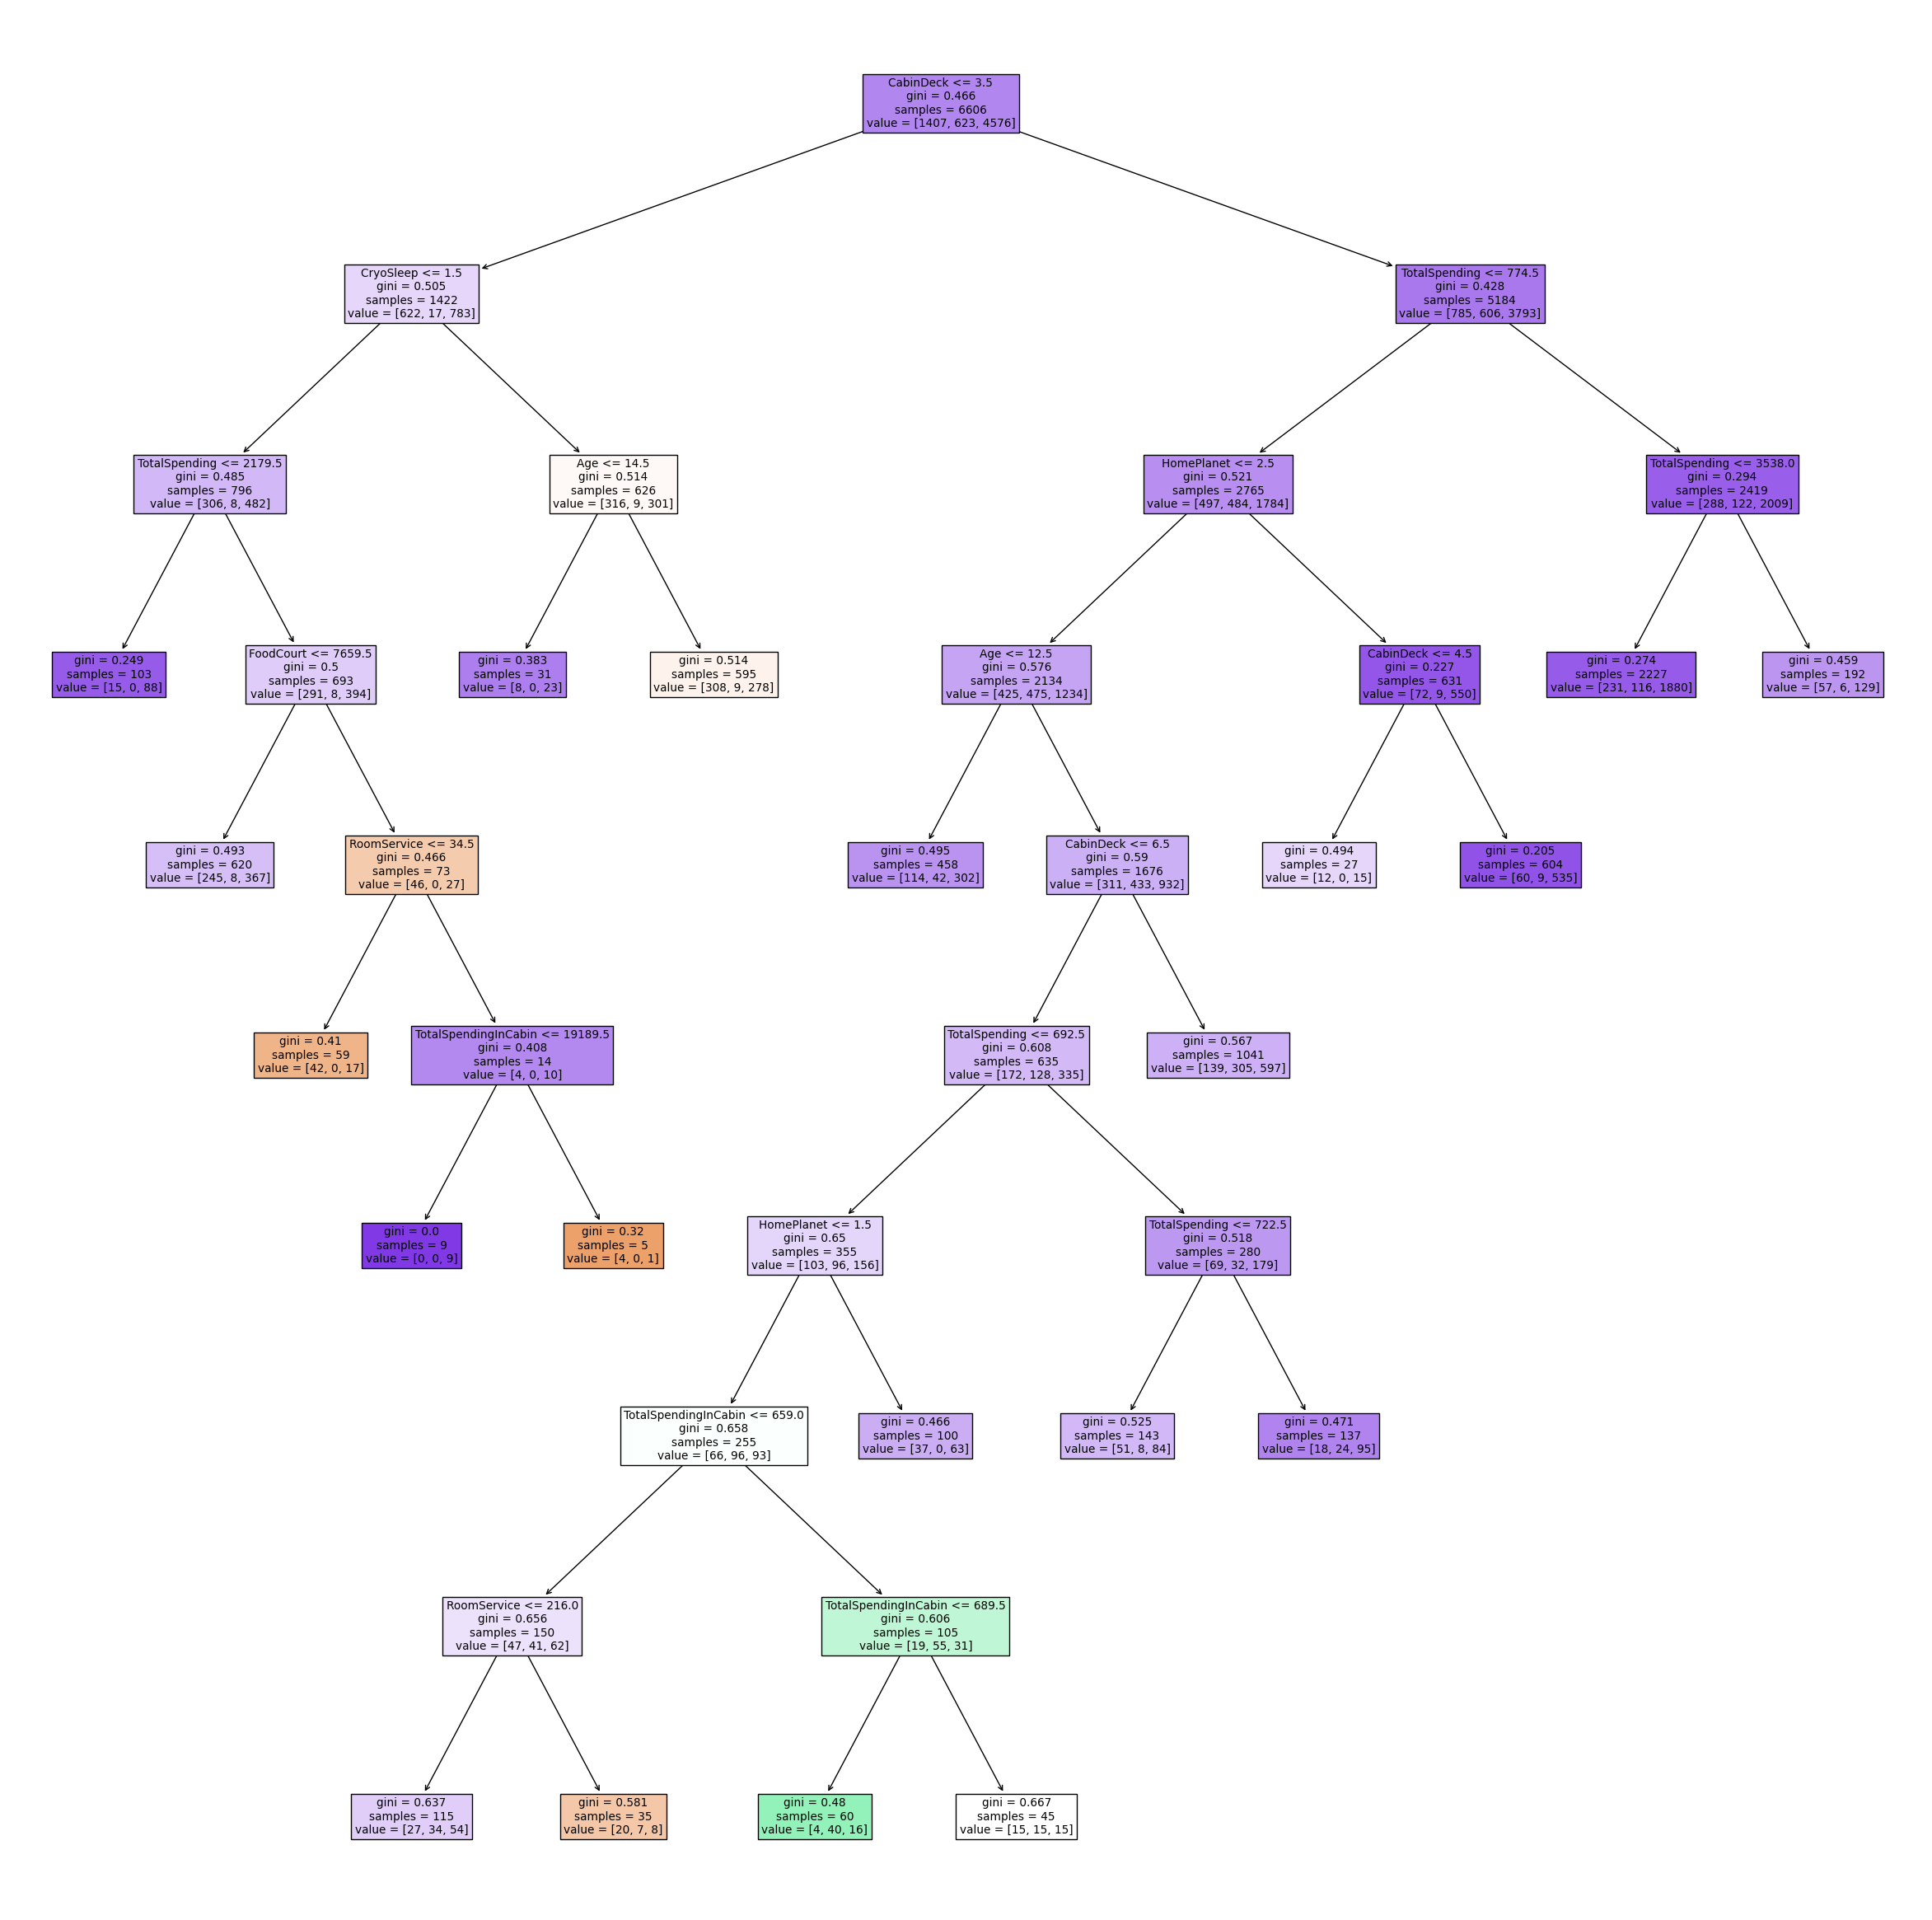

In [7]:
dep_var = 'Destination'
procs = [Categorify]

cat = ['VIP',
       'CabinDeck', 'CabinSide','CryoSleep','HomePlanet']
cont = ['Age','RoomService', 'ShoppingMall', 'Spa', 'VRDeck','CabinNum','FoodCourt','TotalSpending',
        'TotalSpendingInCabin','CabinSize']

to = TabularPandas(traindf, procs, cat, cont, y_names=dep_var)

xs,y = to.train.xs,to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

m = DecisionTreeClassifier(max_leaf_nodes=20)
m.fit(xs, y)

fig = plt.figure(figsize=(30,30))
_ = tree.plot_tree(m,
                   feature_names= xs.columns,
                   filled=True)

#print('decision tree prediction',((m.predict(valid_xs) > 0.5) == valid_y).sum() / len(valid_y))



In [10]:
traindf[(traindf.HomePlanet == 'Europa') & (traindf.Age < 25)].Destination.value_counts()

Destination
TRAPPIST-1e    174
55 Cancri e    132
Name: count, dtype: int64

In [11]:
m.feature_importances_

array([0.        , 0.38286493, 0.        , 0.02558724, 0.20090133, 0.04734199, 0.02175404, 0.        , 0.        , 0.        , 0.        , 0.01661123, 0.26914742, 0.03579182, 0.        ])

In [12]:
traindf.CryoSleep

0       False
1       False
2       False
3       False
4       False
        ...  
8688    False
8689     True
8690    False
8691    False
8692    False
Name: CryoSleep, Length: 6606, dtype: object

In [1]:
traindf[(traindf['CryoSleep'] == False) & (traindf['TotalSpending'] == 0) & (traindf.Age >13)].Destination.value_counts()

NameError: name 'traindf' is not defined

In [14]:



list(zip(traindf.CabinDeck.unique(),xs.CabinDeck.unique()))



[('B', 2),
 ('F', 6),
 ('A', 1),
 ('G', 7),
 ('E', 5),
 ('C', 3),
 ('D', 4),
 ('T', 8)]

In [19]:
traindf[traindf.CabinDeck == ''].Destination.value_counts()

Destination
TRAPPIST-1e      1308
PSO J318.5-22     372
55 Cancri e       293
Name: count, dtype: int64

In [12]:


def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)
print(fi[:30])



                    cols       imp
1              CabinDeck  0.382865
12         TotalSpending  0.269147
4             HomePlanet  0.200901
5                    Age  0.047342
13  TotalSpendingInCabin  0.035792
3              CryoSleep  0.025587
6            RoomService  0.021754
11             FoodCourt  0.016611
0                    VIP  0.000000
2              CabinSide  0.000000
7           ShoppingMall  0.000000
8                    Spa  0.000000
9                 VRDeck  0.000000
10              CabinNum  0.000000
14             CabinSize  0.000000


In [16]:
raindf = traindf.drop(columns = ['PassengerId','CabinNum','FirstName','LastName','TotalSpending','Cabin','Group'])
raindf = pd.get_dummies(raindf)
raindf

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpendingInCabin,CabinSize,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,VIP_False,VIP_True,GroupNumber_01,GroupNumber_02,GroupNumber_03,GroupNumber_04,GroupNumber_05,GroupNumber_06,GroupNumber_07,GroupNumber_08,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S
0,39.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1,False,True,False,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True,736.0,1,True,False,False,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,15559.0,2,False,True,False,True,False,False,False,True,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,15559.0,2,False,True,False,True,False,False,False,True,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True
4,16.0,303.0,70.0,151.0,565.0,2.0,True,1091.0,1,True,False,False,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,8536.0,1,False,True,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1,True,False,False,False,True,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,1873.0,1,True,False,False,True,False,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,9463.0,2,False,True,False,True,False,True,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True


In [17]:
traindf.Destination.value_counts()

Destination
TRAPPIST-1e      4576
55 Cancri e      1407
PSO J318.5-22     623
Name: count, dtype: int64

In [18]:
traindf[traindf.HomePlanet == 'Mars'].Destination.value_counts()

Destination
TRAPPIST-1e      1177
55 Cancri e       152
PSO J318.5-22      38
Name: count, dtype: int64

In [19]:

df_all_corr = raindf.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Destination_55 Cancri e']

,Feature 1,Feature 2,Correlation Coefficient
9,Destination_55 Cancri e,Destination_55 Cancri e,1.000000
43,Destination_55 Cancri e,Destination_TRAPPIST-1e,0.781056
102,Destination_55 Cancri e,HomePlanet_Europa,0.294744
210,Destination_55 Cancri e,CabinDeck_B,0.183092
227,Destination_55 Cancri e,CabinDeck_C,0.170193
233,Destination_55 Cancri e,Destination_PSO J318.5-22,0.167869
238,Destination_55 Cancri e,TotalSpendingInCabin,0.166455
269,Destination_55 Cancri e,HomePlanet_Earth,0.153941
316,Destination_55 Cancri e,FoodCourt,0.133108
328,Destination_55 Cancri e,HomePlanet_Mars,0.127005


In [17]:
def proportion_same_homeplanet_in_cabin(df):
    grouped = df.groupby('Cabin')
    same_homeplanet_count = 0
    total_count = 0
    for cabin, group in grouped:
        if group['Destination'].nunique() == 1:
            same_homeplanet_count += 1
        total_count += 1
    proportion = same_homeplanet_count / total_count
    return proportion

proportion = proportion_same_homeplanet_in_cabin(traindf)
print(f"The proportion of people sharing a cabin with all members from the same home planet is: {proportion:.2%}")


The proportion of people sharing a cabin with all members from the same home planet is: 91.46%


In [20]:
def proportion_same_destination_in_group(df):
    same_destination_count = 0
    total_count = 0
    for group, group_df in df.groupby(['Group', 'LastName','Cabin']):
        if group_df['Destination'].nunique() == 1:
            same_destination_count += 1
        total_count += 1
    proportion = same_destination_count / total_count
    return proportion

proportion = proportion_same_destination_in_group(traindf)
print(f"The proportion of people in the same group and last name with the same destination is: {proportion:.2%}")


The proportion of people in the same group and last name with the same destination is: 92.60%


In [52]:
def proportion_same_destination_in_groups(df):
    same_destination_count = 0
    total_count = 0
    grouped = df.groupby(['LastName', 'Group', 'Cabin', 'CryoSleep'])
    for group_key, group_df in grouped:
        if len(group_df) >= 2 and group_df['Destination'].nunique() == 1:
            same_destination_count += len(group_df)
        total_count += len(group_df)
    proportion = same_destination_count / total_count
    return proportion

proportion = proportion_same_destination_in_groups(traindf)
print(f"The proportion of people with matching conditions and the same destination is: {proportion:.2%}")


The proportion of people with matching conditions and the same destination is: 9.70%


In [53]:
traindf[traindf.LastName == 'Acobson']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,GroupNumber,TotalSpending,TotalSpendingInCabin,CabinSize,CabinDeck,CabinSide,CabinNum,FirstName,LastName
3957,4220_01,Earth,False,E/263/P,TRAPPIST-1e,31.0,False,553.0,224.0,9.0,1.0,0.0,False,4220,01,787.0,787.0,1,E,P,263,Tine,Acobson
6540,6905_01,Earth,False,F/1322/S,TRAPPIST-1e,39.0,False,130.0,741.0,0.0,0.0,0.0,False,6905,01,871.0,1667.0,2,F,S,1322,Vana,Acobson
6541,6905_02,Earth,False,E/460/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,938.0,44.0,False,6905,02,982.0,982.0,1,E,S,460,Lilasa,Acobson
6542,6905_03,Earth,False,F/1322/S,55 Cancri e,16.0,False,43.0,3.0,750.0,0.0,0.0,True,6905,03,796.0,1667.0,2,F,S,1322,Gaylah,Acobson


In [51]:
grouped.

In [59]:
grouped = traindf.groupby(['LastName', 'Group', 'Cabin', 'CryoSleep'])
filtered_groups = grouped.filter(lambda group: len(group) >= 2)
filtered_groups


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,GroupNumber,TotalSpending,TotalSpendingInCabin,CabinSize,CabinDeck,CabinSide,CabinNum,FirstName,LastName
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,01,10383.0,15559.0,2,A,S,0,Altark,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,02,5176.0,15559.0,2,A,S,0,Solam,Susent
21,0020_01,Earth,True,E/0/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,False,0020,01,0.0,0.0,4,E,S,0,Almary,Brantuarez
22,0020_02,Earth,True,E/0/S,55 Cancri e,49.0,False,0.0,0.0,0.0,0.0,0.0,False,0020,02,0.0,0.0,4,E,S,0,Glendy,Brantuarez
33,0031_01,Mars,False,F/9/P,TRAPPIST-1e,47.0,False,214.0,0.0,1411.0,0.0,1229.0,True,0031,01,2854.0,2854.0,2,F,P,9,Coobix,Datie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8679,9267_02,Europa,True,E/607/S,TRAPPIST-1e,20.0,False,0.0,0.0,0.0,0.0,0.0,True,9267,02,0.0,0.0,2,E,S,607,Sabi,Opshaft
8685,9275_01,Europa,False,A/97/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,9275,01,0.0,1231.0,2,A,P,97,Polaton,Conable
8686,9275_02,Europa,False,A/97/P,TRAPPIST-1e,32.0,False,1.0,1146.0,0.0,50.0,34.0,False,9275,02,1231.0,1231.0,2,A,P,97,Diram,Conable
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,9280,01,4637.0,9463.0,2,E,S,608,Celeon,Hontichre


In [198]:
grouped = traindf.groupby(['LastName', 'Group', 'Cabin'])
filtered_groups = grouped.filter(lambda group: len(group) >= 2)
filtered_groups


count = 0
true = 0
i = 0
dftrue = pd.DataFrame()
dffalse = pd.DataFrame()
for item in filtered_groups.index:
    cab = traindf.loc[item].Cabin

    if traindf[traindf.Cabin == cab].CryoSleep.nunique() == 1:
        i += 1
        cab = traindf.loc[item].Cabin
        age = traindf.loc[item].Age
        lastname = traindf.loc[item].LastName
        group = traindf[(traindf.Cabin == cab) & ( age - 1 < traindf.Age) & (traindf.Age < age + 1) & (traindf.LastName == lastname)]
        if len(group) > 1:
            if group.Destination.nunique() == 1:
                dftrue = pd.concat([dftrue,group])
                true += 1
                count += 1
                
            else:
                dffalse = pd.concat([dffalse,group])
                count += 1
print(true/count)



0.5


In [208]:
import pandas as pd

# Assuming your DataFrame is named traindf
duplicates_df = traindf[traindf.duplicated(subset=['LastName', 'Age','Cabin'], keep=False)]

# duplicates_df will now contain only the rows where both last name and age are shared with someone else
duplicates_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,GroupNumber,TotalSpending,TotalSpendingInCabin,CabinSize,CabinDeck,CabinSide,CabinNum,FirstName,LastName
89,0098_01,Earth,False,G/11/P,TRAPPIST-1e,26.0,False,0.0,856.0,5.0,32.0,0.0,False,0098,01,893.0,4748.0,2,G,P,11,Doria,Carezquez
90,0098_02,Earth,False,G/11/P,TRAPPIST-1e,26.0,False,0.0,2811.0,957.0,0.0,87.0,True,0098,02,3855.0,4748.0,2,G,P,11,Leence,Carezquez
363,0401_01,Mars,False,D/14/S,TRAPPIST-1e,30.0,True,1056.0,0.0,0.0,0.0,0.0,False,0401,01,1056.0,2839.0,2,D,S,14,Luse,Pimne
364,0401_02,Mars,False,D/14/S,TRAPPIST-1e,30.0,False,1770.0,0.0,0.0,13.0,0.0,False,0401,02,1783.0,2839.0,2,D,S,14,Parney,Pimne
466,0504_01,Europa,True,B/19/S,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,True,0504,01,0.0,2901.0,4,B,S,19,Thabius,Unpasine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8470,9046_02,Europa,False,C/335/S,TRAPPIST-1e,25.0,False,6899.0,265.0,0.0,2234.0,2090.0,False,9046,02,11488.0,11488.0,2,C,S,335,Quarke,Cratrave
8495,9074_02,Earth,False,G/1460/S,PSO J318.5-22,27.0,False,0.0,468.0,0.0,59.0,309.0,False,9074,02,836.0,836.0,5,G,S,1460,Janee,Trerady
8496,9074_03,Earth,True,G/1460/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,False,9074,03,0.0,836.0,5,G,S,1460,Gwendy,Trerady
8575,9157_04,Earth,False,G/1476/S,55 Cancri e,12.0,False,0.0,0.0,0.0,0.0,0.0,True,9157,04,0.0,1821.0,7,G,S,1476,Arla,Navages


In [199]:
dffalse.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending,TotalSpendingInCabin,CabinSize,CabinNum
count,16.00000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0,16.000000
mean,31.00000,103.875000,2380.750000,35.250000,919.500000,634.000000,4073.375000,8146.750000,2.0,166.250000
std,4.06612,185.551026,2672.581761,78.768437,1053.914861,1048.297159,2622.706436,4409.129884,0.0,145.164504
min,25.00000,0.000000,0.000000,0.000000,0.000000,8.000000,683.000000,1484.000000,2.0,13.000000
25%,28.75000,0.000000,97.000000,0.000000,179.250000,22.500000,2568.000000,5922.500000,2.0,32.500000
50%,32.00000,5.500000,2029.500000,0.500000,449.000000,199.500000,4040.500000,9371.500000,2.0,172.000000
75%,34.25000,114.250000,3428.250000,14.750000,1371.000000,537.750000,5004.250000,11595.750000,2.0,305.750000
max,35.00000,553.000000,7992.000000,234.000000,2761.000000,3156.000000,8524.000000,12360.000000,2.0,308.000000


In [200]:
dftrue.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpending,TotalSpendingInCabin,CabinSize,CabinNum
count,16.00000,16.000000,16.000000,16.00000,16.000000,16.000000,16.000000,16.000000,16.0,16.000000
mean,28.25000,514.000000,726.625000,170.75000,406.750000,53.750000,1871.875000,3743.750000,2.0,72.000000
std,7.81025,631.824659,961.456664,323.04169,656.685567,77.098638,923.328246,731.839463,0.0,92.413563
min,18.00000,0.000000,0.000000,0.00000,0.000000,0.000000,893.000000,2839.000000,2.0,11.000000
25%,24.00000,0.000000,0.000000,0.00000,0.000000,0.000000,1305.000000,3257.500000,2.0,13.250000
50%,28.00000,249.500000,310.500000,2.50000,22.500000,0.000000,1698.500000,3694.000000,2.0,25.500000
75%,32.25000,854.250000,1023.250000,154.00000,497.250000,101.750000,1988.000000,4180.250000,2.0,84.250000
max,39.00000,1770.000000,2811.000000,957.00000,1710.000000,197.000000,3855.000000,4748.000000,2.0,226.000000


In [196]:
dffalse

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,GroupNumber,TotalSpending,TotalSpendingInCabin,CabinSize,CabinDeck,CabinSide,CabinNum,FirstName,LastName
96,0103_02,Earth,True,G/18/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,True,0103,02,0.0,0.0,2,G,S,18,Shaele,Mclainez
97,0103_03,Earth,True,G/18/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,False,0103,03,0.0,0.0,2,G,S,18,Fanne,Mclainez
96,0103_02,Earth,True,G/18/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,True,0103,02,0.0,0.0,2,G,S,18,Shaele,Mclainez
97,0103_03,Earth,True,G/18/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,False,0103,03,0.0,0.0,2,G,S,18,Fanne,Mclainez
398,0437_01,Earth,False,F/78/S,TRAPPIST-1e,39.0,False,382.0,0.0,22.0,467.0,0.0,False,0437,01,871.0,1744.0,2,F,S,78,Lynnee,Oneiles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649,9227_03,Earth,True,G/1498/P,PSO J318.5-22,1.0,False,0.0,0.0,0.0,0.0,0.0,True,9227,03,0.0,0.0,4,G,P,1498,Paulas,Hinglendez
8650,9227_04,Earth,True,G/1498/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,True,9227,04,0.0,0.0,4,G,P,1498,Robyny,Hinglendez
8647,9227_01,Earth,True,G/1498/P,TRAPPIST-1e,7.0,False,0.0,0.0,0.0,0.0,0.0,False,9227,01,0.0,0.0,4,G,P,1498,Glendy,Hinglendez
8649,9227_03,Earth,True,G/1498/P,PSO J318.5-22,1.0,False,0.0,0.0,0.0,0.0,0.0,True,9227,03,0.0,0.0,4,G,P,1498,Paulas,Hinglendez
